\begin{equation}
\frac{d\rho}{dt} = -i[H(t), \rho] + \sum_k \left( c_k \rho c_k^\dagger - \frac{1}{2} \left\{ c_k^\dagger c_k, \rho \right\} \right)
\end{equation}

using a first-order Euler method, which approximates the density matrix at the next time step as:
\begin{equation}
\rho(t + \Delta t) \approx \rho(t) + \Delta t \cdot \frac{d\rho}{dt}
\end{equation}

In [29]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Parameters
gamma_m = 1.0              # measurement strength
Omega_0 = 0.01 * gamma_m    # Hamiltonian strength
sigma = 10                 # pulse width
top = 125 / gamma_m        # t_op the time of evolution
gamma = 1.25e-4 * gamma_m  # bit flip error rate
eta = 1                    # quantum efficiency (1 for ideal detectors)
tau = 2.5 / gamma_m       # measurement time parameter
dt = 0.01  # time step

N = 9
Tc = 0.00005

# Thresholds
theta1 = 0.56
theta2 = -0.56

theta_z1 = theta_x1 = +1.4
theta_z2 = theta_x2 = -0.40


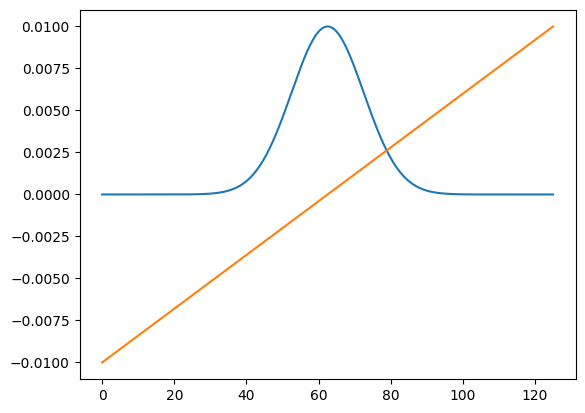

In [31]:
tlist = np.arange(0, top, dt)

# Filtering constant
alpha = dt / tau

# Pauli matrices and identity
I, X, Z, Y = qeye(2), sigmax(), sigmaz(), sigmay()

omega_t = lambda t: Omega_0 * np.exp(-0.5 * ((t - top / 2) / sigma) ** 2)
delta_t = lambda t: Omega_0 * (t / (top / 2) - 1)

plt.plot(tlist, omega_t(tlist))
plt.plot(tlist, delta_t(tlist))
plt.show()

In [32]:
def op_on_qubit(op, i):
    return tensor([op if k == i else I for k in range(N)])
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [33]:
# Pauli operators on 3 qubits
X1, X2, X3, X4, X5, X6, X7, X8, X9 = [op_on_qubit(X, i) for i in range(N)]
Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9 = [op_on_qubit(Z, i) for i in range(N)]
Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9 = [op_on_qubit(Y, i) for i in range(N)]
I_all = tensor([I for _ in range(N)])

# Stabilizers
S1 = Z1 * Z2 * Z3 * Z4 * Z5 * Z6
S2 = Z4 * Z5 * Z6 * Z7 * Z8 * Z9
S3 = X1 * X2 * X4 * X5 * X7 * X8
S4 = X2 * X3 * X5 * X6 * X8 * X9


syndrome_map = {
    (+1, +1, +1, -1): X7,                  # Correct by X7, X8, or X9 (choose one, e.g., X7)
    (+1, +1, -1, -1): Y9,                  # Correct by Y9
    (+1, +1, -1, +1): Z9,                  # Correct by Z3, Z6, or Z9 (choose one, e.g., Z9)
    (+1, -1, +1, +1): X1,                  # Correct by X1, X2, or X3 (choose one, e.g., X1)
    (+1, -1, +1, -1): X4,                  # Correct by X4, X5, or X6 (choose one, e.g., X4)
    (+1, -1, -1, -1): Y6,                  # Correct by Y6
    (+1, -1, -1, +1): Y3,                  # Correct by Y3
    (-1, -1, +1, +1): Y1,                  # Correct by Y1
    (-1, -1, +1, -1): Y4,                  # Correct by Y4
    (-1, -1, -1, -1): Y5,                  # Correct by Y5
    (-1, -1, -1, +1): Y2,                  # Correct by Y2
    (-1, +1, +1, +1): Z1,                  # Correct by Z1, Z4, or Z7 (choose one, e.g., Z1)
    (-1, +1, +1, -1): Y7,                  # Correct by Y7
    (-1, +1, -1, -1): Y8,                  # Correct by Y8
    (-1, +1, -1, +1): Z2,                  # Correct by Z2, Z5, or Z8 (choose one, e.g., Z2)
}

G_X = [X1 * X2,
     X4 * X5,
     X7 * X8,
     X2 * X3,
     X5 * X6,
     X8 * X9]

G_Z = [Z1 * Z4, 
     Z2 * Z5, 
     Z3 * Z6,
     Z4 * Z7,
     Z5 * Z8,
     Z6 * Z9]

G = G_Z + G_X

define code space

In [34]:
# Target logical states for fidelity
phi1 = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)) + 
                tensor(basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 1), basis(2, 0)) + 
                tensor(basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 1)) + 
                tensor(basis(2, 0), basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 1), basis(2, 1))).unit()

phi2 = X8*X9 * phi1
phi3 = X7*X8 * phi1
phi4 = X7*X9 * phi1
phi5 = X5*X6 * phi1
phi6 = X5*X6 * phi2
phi7 = X5*X6 * phi3
phi8 = X5*X6 * phi4
phi9 = X4*X5 * phi1
phi10 = X4*X5 * phi2
phi11 = X4*X5 * phi3
phi12 = X4*X5 * phi4
phi13 = X4*X6 * phi1
phi14 = X4*X6 * phi2
phi15 = X4*X6 * phi3
phi16 = X4*X6 * phi4

Q0_plus = [phi1, phi2, phi3, phi4, phi5, phi6, phi7, phi8, phi9, phi10, phi11, phi12, phi13, phi14, phi15, phi16]
Q0_minus = [X1*X2*X3*X4*X5*X6*X7*X8*X9 * i for i in Q0_plus]
Q0 = Q0_plus + Q0_minus

# test = []
# for g in G:
#     for phi in Q0:
#         test.append(g*phi)
# 
# for phi in test:
#     if not (S1*phi == phi and S2*phi == phi and S3*phi == phi and S4*phi == phi):
#         print("Not stabilizer")
#         

In [35]:
# Collapse operators (bit-flip noise)
c_ops = [np.sqrt(gamma) * i for i in list(syndrome_map.values())]
# c_ops = [np.sqrt(gamma) * i for i in [X1, X2, X3, X4, X5, X6, X7, X8, X9]]

# Target logical states for fidelity
zero = Q0[0]

X_L = X1*X4*X7
Z_L = Z1*Z2*Z3

one = X_L*zero

# Initial state: logical |0_L> = |000>
psi0 = zero
rho = ket2dm(psi0)

# Initialize filtered stabilizer signals
I1_bar, I2_bar, I3_bar, I4_bar, I5_bar, I6_bar, I7_bar, I8_bar, I9_bar, I10_bar, I11_bar, I12_bar = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

# Record fidelity
fidelities_1 = []
fidelities_2 = []
fidelities_3 = []
fidelities_4 = []
fidelities_5 = []
fidelities_6 = []
fidelities_7 = []
fidelities_8 = []
fidelities_9 = []
fidelities_10= []
fidelities_11 = []
fidelities_12 = []
fidelities_13 = []
fidelities_14 = []
fidelities_15 = []
fidelities_16 = []
fidelities_17 = []
fidelities_18 = []
fidelities_19 = []
fidelities_20 = []
fidelities_21 = []
fidelities_22 = []
fidelities_23= []
fidelities_24 = []
fidelities_25 = []
fidelities_26 = []
fidelities_27 = []
fidelities_28 = []
fidelities_29 = []
fidelities_30 = []
fidelities_31 = []
fidelities_32 = []


fidelities_0_L = []
fidelities_1_L = []
errors = []


I1s, I2s, I3s, I4s, I5s, I6s, I7s, I8s, I9s, I10s, I11s, I12s = [], [], [], [], [], [], [], [], [], [], [], []

Cz1, Cz2, Cx1, Cx2 = 0.0, 0.0, 0.0, 0.0

Cz1s, Cz2s, Cx1s, Cx2s = [], [], [], []

# for time tracking
import time
start_time = time.time()

# Time evolution loop
for i, t in enumerate(tlist):
    # Hamiltonian
    H = X_L*omega_t(t) + Z_L*delta_t(t)

    # Effective SME step
    dW1, dW2, dW3, dW4, dW5, dW6, dW7, dW8, dW9, dW10, dW11, dW12 = np.random.normal(scale=np.sqrt(dt), size=12)

    
    meas1, meas2, meas3, meas4, meas5, meas6, meas7, meas8, meas9, meas10, meas11, meas12 = [(np.sqrt(2 * gamma_m * eta) * (G_i * rho + rho * G_i - 2 * expect(G_i, rho) * rho)) for G_i in G]
    
    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
        
    for G_i in G:
        drho += gamma_m * (G_i * rho * G_i - 0.5 * (G_i**2 * rho + rho * G_i**2))
    
    drho += meas1 * dW1 + meas2 * dW2 + meas3 * dW3 + meas4 * dW4 + meas5 * dW5 + meas6 * dW6 + meas7 * dW7 + meas8 * dW8 + meas9 * dW9 + meas10 * dW10 + meas11 * dW11 + meas12 * dW12

    rho = (rho + dt * drho).unit()

    # Measurement currents (with noise)
    I1 = expect(G[0], rho) + dW1 / np.sqrt(dt)
    I2 = expect(G[1], rho) + dW2 / np.sqrt(dt)
    I3 = expect(G[2], rho) + dW3 / np.sqrt(dt)
    I4 = expect(G[3], rho) + dW4 / np.sqrt(dt)
    I5 = expect(G[4], rho) + dW5 / np.sqrt(dt)
    I6 = expect(G[5], rho) + dW6 / np.sqrt(dt)
    I7 = expect(G[6], rho) + dW7 / np.sqrt(dt)
    I8 = expect(G[7], rho) + dW8 / np.sqrt(dt)
    I9 = expect(G[8], rho) + dW9 / np.sqrt(dt)
    I10 = expect(G[9], rho) + dW10 / np.sqrt(dt)
    I11 = expect(G[10], rho) + dW11 / np.sqrt(dt)
    I12 = expect(G[11], rho) + dW12 / np.sqrt(dt)

    # Exponential filtering
    I1_bar = (1 - alpha) * I1_bar + alpha * I1
    I2_bar = (1 - alpha) * I2_bar + alpha * I2
    I3_bar = (1 - alpha) * I3_bar + alpha * I3
    I4_bar = (1 - alpha) * I4_bar + alpha * I4
    I5_bar = (1 - alpha) * I5_bar + alpha * I5
    I6_bar = (1 - alpha) * I6_bar + alpha * I6
    I7_bar = (1 - alpha) * I7_bar + alpha * I7
    I8_bar = (1 - alpha) * I8_bar + alpha * I8
    I9_bar = (1 - alpha) * I9_bar + alpha * I9
    I10_bar = (1 - alpha) * I10_bar + alpha * I10
    I11_bar = (1 - alpha) * I11_bar + alpha * I11
    I12_bar = (1 - alpha) * I12_bar + alpha * I12
    
    I1s.append(I1_bar)
    I2s.append(I2_bar)
    I3s.append(I3_bar)
    I4s.append(I4_bar)
    I5s.append(I5_bar)
    I6s.append(I6_bar)
    I7s.append(I7_bar)
    I8s.append(I8_bar)
    I9s.append(I9_bar)
    I10s.append(I10_bar)
    I11s.append(I11_bar)
    I12s.append(I12_bar)
    
    
    decay = np.exp(-dt / Tc)
    weight = dt / Tc

    Cz1 = decay * Cz1 + weight * (I1_bar * I2_bar * I3_bar)
    Cz2 = decay * Cz2 + weight * (I4_bar * I5_bar * I6_bar)
    Cx1 = decay * Cx1 + weight * (I7_bar * I8_bar * I9_bar)
    Cx2 = decay * Cx2 + weight * (I10_bar * I11_bar * I12_bar)
    
    Cz1s.append(Cz1)
    Cz2s.append(Cz2)
    Cx1s.append(Cx1)
    Cx2s.append(Cx2)
    
    
    s_z1 = +1 if Cz1 > theta_z2 else -1 if Cz1 < theta_z1 else 0
    s_z2 = +1 if Cz2 > theta_z2 else -1 if Cz2 < theta_z1 else 0
    s_x1 = +1 if Cx1 > theta_x2 else -1 if Cx1 < theta_x1 else 0
    s_x2 = +1 if Cx2 > theta_x2 else -1 if Cx2 < theta_x1 else 0

    syndrome = (s_x1, s_z1, s_x2, s_z2)
    if syndrome in syndrome_map:
        rho = syndrome_map[syndrome] * rho * syndrome_map[syndrome].dag()
        errors.append((f"Corrected: {syndrome}", t))

    # fidelities.append((psi_target.dag() * rho * psi_target))
    fidelities_1.append((zero.dag() * rho * zero))
    fidelities_2.append((one.dag() * rho * one))
    
    # fidelities_1.append((phi1.dag() * rho * phi1))
    # fidelities_2.append((phi2.dag() * rho * phi2))
    fidelities_3.append((phi3.dag() * rho * phi3))
    fidelities_4.append((phi4.dag() * rho * phi4))
    fidelities_5.append((phi5.dag() * rho * phi5))
    fidelities_6.append((phi6.dag() * rho * phi6))
    fidelities_7.append((phi7.dag() * rho * phi7))
    fidelities_8.append((phi8.dag() * rho * phi8))
    fidelities_9.append((phi9.dag() * rho * phi9))
    fidelities_10.append((phi10.dag() * rho * phi10))
    fidelities_11.append((phi11.dag() * rho * phi11))
    fidelities_12.append((phi12.dag() * rho * phi12))
    fidelities_13.append((phi13.dag() * rho * phi13))
    fidelities_14.append((phi14.dag() * rho * phi14))
    fidelities_15.append((phi15.dag() * rho * phi15))
    fidelities_16.append((phi16.dag() * rho * phi16))
    fidelities_17.append((Q0[16].dag() * rho * Q0[16]))
    fidelities_18.append((Q0[17].dag() * rho * Q0[17]))
    fidelities_19.append((Q0[18].dag() * rho * Q0[18]))
    fidelities_20.append((Q0[19].dag() * rho * Q0[19]))
    fidelities_21.append((Q0[20].dag() * rho * Q0[20]))
    fidelities_22.append((Q0[21].dag() * rho * Q0[21]))
    fidelities_23.append((Q0[22].dag() * rho * Q0[22]))
    fidelities_24.append((Q0[23].dag() * rho * Q0[23]))
    fidelities_25.append((Q0[24].dag() * rho * Q0[24]))
    fidelities_26.append((Q0[25].dag() * rho * Q0[25]))
    fidelities_27.append((Q0[26].dag() * rho * Q0[26]))
    fidelities_28.append((Q0[27].dag() * rho * Q0[27]))
    fidelities_29.append((Q0[28].dag() * rho * Q0[28]))
    fidelities_30.append((Q0[29].dag() * rho * Q0[29]))
    fidelities_31.append((Q0[30].dag() * rho * Q0[30]))
    fidelities_32.append((Q0[31].dag() * rho * Q0[31]))
    
    # Print progress every 10 iterations and if i > 0 for a valid estimation.
    if i % 10 == 0 and i > 0:
        elapsed_time = time.time() - start_time
        total_iters = len(tlist)
        estimated_total_time = elapsed_time / i * total_iters
        estimated_time_left = estimated_total_time - elapsed_time
        print(f"{(t/top)*100:.2f}% done")
        print(f"Estimated time left: {estimated_time_left/60:.2f} minutes")
        
print(errors)

0.08% done
Estimated time left: 156.76 minutes
0.16% done
Estimated time left: 142.56 minutes
0.24% done
Estimated time left: 138.17 minutes
0.32% done
Estimated time left: 136.77 minutes
0.40% done
Estimated time left: 136.06 minutes
0.48% done
Estimated time left: 135.01 minutes
0.56% done
Estimated time left: 134.48 minutes
0.64% done
Estimated time left: 134.03 minutes
0.72% done
Estimated time left: 136.61 minutes
0.80% done
Estimated time left: 135.84 minutes
0.88% done
Estimated time left: 135.52 minutes
0.96% done
Estimated time left: 134.70 minutes
1.04% done
Estimated time left: 134.50 minutes
1.12% done
Estimated time left: 135.04 minutes
1.20% done
Estimated time left: 134.43 minutes
1.28% done
Estimated time left: 133.79 minutes
1.36% done
Estimated time left: 133.00 minutes
1.44% done
Estimated time left: 132.44 minutes
1.52% done
Estimated time left: 131.78 minutes
1.60% done
Estimated time left: 131.38 minutes
1.68% done
Estimated time left: 130.74 minutes
1.76% done
Es

(0.939981249999996+0j)


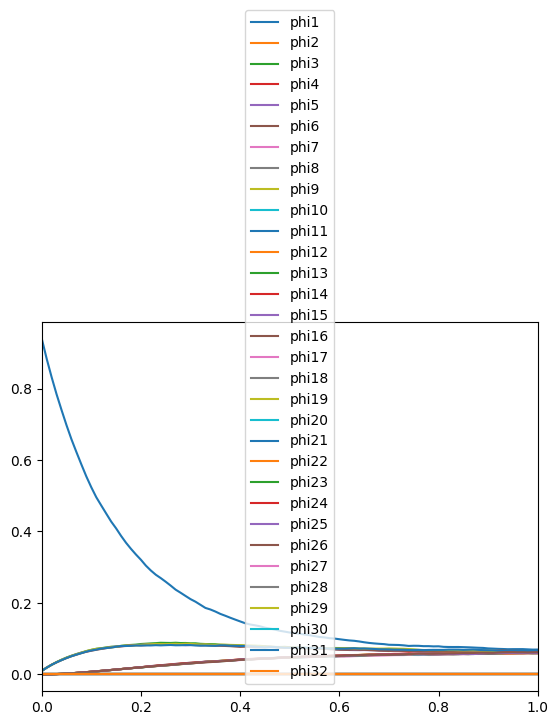

In [41]:
plt.plot(tlist, fidelities_1, label='phi1')
plt.plot(tlist, fidelities_2, label='phi2')
plt.plot(tlist, fidelities_3, label='phi3')
plt.plot(tlist, fidelities_4, label='phi4')
plt.plot(tlist, fidelities_5, label='phi5')
plt.plot(tlist, fidelities_6, label='phi6')
plt.plot(tlist, fidelities_7, label='phi7')
plt.plot(tlist, fidelities_8, label='phi8')
plt.plot(tlist, fidelities_9, label='phi9')
plt.plot(tlist, fidelities_10, label='phi10')
plt.plot(tlist, fidelities_11, label='phi11')
plt.plot(tlist, fidelities_12, label='phi12')
plt.plot(tlist, fidelities_13, label='phi13')
plt.plot(tlist, fidelities_14, label='phi14')
plt.plot(tlist, fidelities_15, label='phi15')
plt.plot(tlist, fidelities_16, label='phi16')
plt.plot(tlist, fidelities_17, label='phi17')
plt.plot(tlist, fidelities_18, label='phi18')
plt.plot(tlist, fidelities_19, label='phi19')
plt.plot(tlist, fidelities_20, label='phi20')
plt.plot(tlist, fidelities_21, label='phi21')
plt.plot(tlist, fidelities_22, label='phi22')
plt.plot(tlist, fidelities_23, label='phi23')
plt.plot(tlist, fidelities_24, label='phi24')
plt.plot(tlist, fidelities_25, label='phi25')
plt.plot(tlist, fidelities_26, label='phi26')
plt.plot(tlist, fidelities_27, label='phi27')
plt.plot(tlist, fidelities_28, label='phi28')
plt.plot(tlist, fidelities_29, label='phi29')
plt.plot(tlist, fidelities_30, label='phi30')
plt.plot(tlist, fidelities_31, label='phi31')
plt.plot(tlist, fidelities_32, label='phi32')
plt.xlim([0,1])
print(fidelities_1[0])
plt.legend()
plt.show()

Testing

In [ ]:
zero = Q0[0]

X_L = X1*X4*X7
Z_L = Z1*Z2*Z3

one = X_L*zero

psi0 = Q0[0]

print("zero")
print_quantum_state_as_superposition(zero)

print("one")
print_quantum_state_as_superposition(one)

print("phi17")
print_quantum_state_as_superposition(Q0[16])

In [ ]:
Omega_0 = 0.06
sigma = 10
top = 125
omega_t = lambda t: Omega_0 * np.exp(-0.5 * ((t - top / 2) / sigma) ** 2)
delta_t = lambda t: Omega_0 * (t / (top / 2) - 1)

# plt.plot(tlist, omega_t(tlist))
# plt.plot(tlist, delta_t(tlist))


H = lambda t: X_L*omega_t(t) + Z_L*delta_t(t)

dt = 0.1

tlist = np.arange(0, top, dt)


results = sesolve(H, psi0, tlist, e_ops=[zero*zero.dag(), one*one.dag()], )

plt.plot(tlist, results.expect[0], label='0')
plt.plot(tlist, results.expect[1], label='1')
plt.legend()
plt.show()

In [ ]:
gamma = 1.25e-3
# c_ops = [np.sqrt(gamma) * i for i in [X1, X2, X3, X4, X5, X6, X7, X8, X9]]
c_ops = [np.sqrt(gamma) * i for i in list(syndrome_map.values())]

results = mesolve(H, ket2dm(psi0), tlist, c_ops=c_ops, e_ops=[Q0[0]*Q0[0].dag(), one*one.dag()])

plt.plot(tlist, results.expect[0], label='0')
plt.plot(tlist, results.expect[1], label='1')
plt.legend()
plt.show()

In [ ]:
# Initial state: logical |0_L> = |000>
rho = ket2dm(psi0)

# Record fidelity
fidelities_1_no_meas = []
fidelities_2_no_meas = []
fidelities_3_no_meas = []
fidelities_4_no_meas = []
fidelities_5_no_meas = []
fidelities_6_no_meas = []
fidelities_7_no_meas = []
fidelities_8_no_meas = []
fidelities_9_no_meas = []
fidelities_10_no_meas = []
fidelities_11_no_meas = []
fidelities_12_no_meas = []
fidelities_13_no_meas = []
fidelities_14_no_meas = []
fidelities_15_no_meas = []
fidelities_16_no_meas = []
fidelities_17_no_meas = []
fidelities_18_no_meas = []
fidelities_19_no_meas = []
fidelities_20_no_meas = []
fidelities_21_no_meas = []
fidelities_22_no_meas = []
fidelities_23_no_meas = []
fidelities_24_no_meas = []
fidelities_25_no_meas = []
fidelities_26_no_meas = []
fidelities_27_no_meas = []
fidelities_28_no_meas = []
fidelities_29_no_meas = []
fidelities_30_no_meas = []
fidelities_31_no_meas = []
fidelities_32_no_meas = []


# c_ops = [np.sqrt(gamma) * i for i in [X1, X2, X3, X4, X5, X6, X7, X8, X9]]
c_ops = [np.sqrt(gamma) * i for i in list(syndrome_map.values())]


# Time evolution loop
for t in tlist:
    H = X_L*omega_t(t) + Z_L*delta_t(t)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    
    rho = (rho + dt * drho).unit()

    fidelities_1_no_meas.append((phi1.dag() * rho * phi1))
    fidelities_2_no_meas.append((phi2.dag() * rho * phi2))
    fidelities_3_no_meas.append((phi3.dag() * rho * phi3))
    fidelities_4_no_meas.append((phi4.dag() * rho * phi4))
    fidelities_5_no_meas.append((phi5.dag() * rho * phi5))
    fidelities_6_no_meas.append((phi6.dag() * rho * phi6))
    fidelities_7_no_meas.append((phi7.dag() * rho * phi7))
    fidelities_8_no_meas.append((phi8.dag() * rho * phi8))
    fidelities_9_no_meas.append((phi9.dag() * rho * phi9))
    fidelities_10_no_meas.append((phi10.dag() * rho * phi10))
    fidelities_11_no_meas.append((phi11.dag() * rho * phi11))
    fidelities_12_no_meas.append((phi12.dag() * rho * phi12))
    fidelities_13_no_meas.append((phi13.dag() * rho * phi13))
    fidelities_14_no_meas.append((phi14.dag() * rho * phi14))
    fidelities_15_no_meas.append((phi15.dag() * rho * phi15))
    fidelities_16_no_meas.append((phi16.dag() * rho * phi16))
    fidelities_17_no_meas.append((Q0[16].dag() * rho * Q0[16]))
    fidelities_18_no_meas.append((Q0[17].dag() * rho * Q0[17]))
    fidelities_19_no_meas.append((Q0[18].dag() * rho * Q0[18]))
    fidelities_20_no_meas.append((Q0[19].dag() * rho * Q0[19]))
    fidelities_21_no_meas.append((Q0[20].dag() * rho * Q0[20]))
    fidelities_22_no_meas.append((Q0[21].dag() * rho * Q0[21]))
    fidelities_23_no_meas.append((Q0[22].dag() * rho * Q0[22]))
    fidelities_24_no_meas.append((Q0[23].dag() * rho * Q0[23]))
    fidelities_25_no_meas.append((Q0[24].dag() * rho * Q0[24]))
    fidelities_26_no_meas.append((Q0[25].dag() * rho * Q0[25]))
    fidelities_27_no_meas.append((Q0[26].dag() * rho * Q0[26]))
    fidelities_28_no_meas.append((Q0[27].dag() * rho * Q0[27]))
    fidelities_29_no_meas.append((Q0[28].dag() * rho * Q0[28]))
    fidelities_30_no_meas.append((Q0[29].dag() * rho * Q0[29]))
    fidelities_31_no_meas.append((Q0[30].dag() * rho * Q0[30]))
    fidelities_32_no_meas.append((Q0[31].dag() * rho * Q0[31]))
    
    
    print(t*100/top, "%")

In [ ]:
# print(errors)
plt.plot(tlist, fidelities_1, label='phi1')
plt.plot(tlist, fidelities_2, label='phi2')
plt.plot(tlist, fidelities_3, label='phi3')
plt.plot(tlist, fidelities_4, label='phi4')
plt.plot(tlist, fidelities_5, label='phi5')
plt.plot(tlist, fidelities_6, label='phi6')
plt.plot(tlist, fidelities_7, label='phi7')
plt.plot(tlist, fidelities_8, label='phi8')
plt.plot(tlist, fidelities_9, label='phi9')
plt.plot(tlist, fidelities_10, label='phi10')
plt.plot(tlist, fidelities_11, label='phi11')
plt.plot(tlist, fidelities_12, label='phi12')
plt.plot(tlist, fidelities_13, label='phi13')
plt.plot(tlist, fidelities_14, label='phi14')
plt.plot(tlist, fidelities_15, label='phi15')
plt.plot(tlist, fidelities_16, label='phi16')
plt.plot(tlist, fidelities_17, label='phi17')
plt.plot(tlist, fidelities_18, label='phi18')
plt.plot(tlist, fidelities_19, label='phi19')
plt.plot(tlist, fidelities_20, label='phi20')
plt.plot(tlist, fidelities_21, label='phi21')
plt.plot(tlist, fidelities_22, label='phi22')
plt.plot(tlist, fidelities_23, label='phi23')
plt.plot(tlist, fidelities_24, label='phi24')
plt.plot(tlist, fidelities_25, label='phi25')
plt.plot(tlist, fidelities_26, label='phi26')
plt.plot(tlist, fidelities_27, label='phi27')
plt.plot(tlist, fidelities_28, label='phi28')
plt.plot(tlist, fidelities_29, label='phi29')
plt.plot(tlist, fidelities_30, label='phi30')
plt.plot(tlist, fidelities_31, label='phi31')
plt.plot(tlist, fidelities_32, label='phi32')
# 
# plt.plot(tlist, fidelities_1_no_meas, label='phi1')
# plt.plot(tlist, fidelities_2_no_meas, label='phi2')
# plt.plot(tlist, fidelities_3_no_meas, label='phi3')
# plt.plot(tlist, fidelities_4_no_meas, label='phi4')
# plt.plot(tlist, fidelities_5_no_meas, label='phi5')
# plt.plot(tlist, fidelities_6_no_meas, label='phi6')
# plt.plot(tlist, fidelities_7_no_meas, label='phi7')
# plt.plot(tlist, fidelities_8_no_meas, label='phi8')
# plt.plot(tlist, fidelities_9_no_meas, label='phi9')
# plt.plot(tlist, fidelities_10_no_meas, label='phi10')
# plt.plot(tlist, fidelities_11_no_meas, label='phi11')
# plt.plot(tlist, fidelities_12_no_meas, label='phi12')
# plt.plot(tlist, fidelities_13_no_meas, label='phi13')
# plt.plot(tlist, fidelities_14_no_meas, label='phi14')
# plt.plot(tlist, fidelities_15_no_meas, label='phi15')
# plt.plot(tlist, fidelities_16_no_meas, label='phi16')
# plt.plot(tlist, fidelities_17_no_meas, label='phi17')
# plt.plot(tlist, fidelities_18_no_meas, label='phi18')
# plt.plot(tlist, fidelities_19_no_meas, label='phi19')
# plt.plot(tlist, fidelities_20_no_meas, label='phi20')
# plt.plot(tlist, fidelities_21_no_meas, label='phi21')
# plt.plot(tlist, fidelities_22_no_meas, label='phi22')
# plt.plot(tlist, fidelities_23_no_meas, label='phi23')
# plt.plot(tlist, fidelities_24_no_meas, label='phi24')
# plt.plot(tlist, fidelities_25_no_meas, label='phi25')
# plt.plot(tlist, fidelities_26_no_meas, label='phi26')
# plt.plot(tlist, fidelities_27_no_meas, label='phi27')
# plt.plot(tlist, fidelities_28_no_meas, label='phi28')
# plt.plot(tlist, fidelities_29_no_meas, label='phi29')
# plt.plot(tlist, fidelities_30_no_meas, label='phi30')
# plt.plot(tlist, fidelities_31_no_meas, label='phi31')
# plt.plot(tlist, fidelities_32_no_meas, label='phi32')

fidelities_all_0 = [fidelities_1_no_meas[i] + fidelities_2_no_meas[i] +
                  fidelities_3_no_meas[i] + fidelities_4_no_meas[i] +
                  fidelities_5_no_meas[i] + fidelities_6_no_meas[i] +
                  fidelities_7_no_meas[i] + fidelities_8_no_meas[i] +
                  fidelities_9_no_meas[i] + fidelities_10_no_meas[i] +
                  fidelities_11_no_meas[i] + fidelities_12_no_meas[i] +
                  fidelities_13_no_meas[i] + fidelities_14_no_meas[i] +
                  fidelities_15_no_meas[i] + fidelities_16_no_meas[i] for i in range(len(fidelities_1_no_meas))]

fidelities_all_1 = [fidelities_17_no_meas[i] + fidelities_18_no_meas[i] +
                  fidelities_19_no_meas[i] + fidelities_20_no_meas[i] +
                  fidelities_21_no_meas[i] + fidelities_22_no_meas[i] +
                  fidelities_23_no_meas[i] + fidelities_24_no_meas[i] +
                  fidelities_25_no_meas[i] + fidelities_26_no_meas[i] +
                  fidelities_27_no_meas[i] + fidelities_28_no_meas[i] +
                  fidelities_29_no_meas[i] + fidelities_30_no_meas[i] +
                  fidelities_31_no_meas[i] + fidelities_32_no_meas[i] for i in range(len(fidelities_1_no_meas))]

# plt.plot(tlist, fidelities_all_0, label=r'1-16')
# plt.plot(tlist, fidelities_all_1, label=r'17-32')
# plt.plot(tlist, fidelities_0, label=r'$|0_L\rangle$')
# plt.plot(tlist, fidelities_1, label=r'$|1_L\rangle$')

# plt.legend()
plt.show()

print_quantum_state_as_superposition(phi1)
print_quantum_state_as_superposition(phi11)

In [ ]:
plt.plot(tlist, Cz1s, label='I1')
plt.plot(tlist, Cz2s, label='I2')

plt.plot(tlist, Cx1s, label='I1')
plt.plot(tlist, Cx2s, label='I2')

plt.axhline(theta_x1, color='green', linestyle='--', label=f'theta_x1 = {theta_x1}')
plt.axhline(theta_x2, color='green', linestyle='--', label=f'theta_x2 = {theta_x2}')
plt.axhline(theta_z1, color='green', linestyle='--', label=f'theta_z1 = {theta_z1}')
plt.axhline(theta_z2, color='green', linestyle='--', label=f'theta_z2 = {theta_z2}')

# for e in errors:
#     plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
    
# plt.yscale('log')
# plt.xlim([430, 460])# Initial state: logical |0_L> = |000>
# rho = ket2dm(psi0)
# 
# # Record fidelity
# fidelities_0_no_meas = []
# fidelities_1_no_meas = []

# # Time evolution loop
# for t in tlist:
#     H = (X1 * X2 * X3)*omega_t(t) + ((Z1 + Z2 + Z3)/3)*delta_t(t)
# 
#     drho = -1j * (H * rho - rho * H)
#     for c in c_ops:
#         drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
#     
#     rho = (rho + dt * drho).unit()
# 
#     fidelities_0_no_meas.append((zero.dag() * rho * zero))
#     fidelities_1_no_meas.append((one.dag() * rho * one))

# plt.xlim([200, 220])
plt.ylim([-1.5, 1.5])
plt.xlabel('Time')
plt.ylabel('Filtered Signals')
plt.title('Output Filtered Signals as Function of Time')
plt.grid(True)
plt.legend()
plt.show()